# PyTorch MNIST example

In [121]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from sklearn.model_selection import train_test_split



mnist_df = pd.read_csv('MNIST_dataset.csv')

mnist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [122]:
# Split the data into images and labels
images = mnist_df.drop('labels', axis=1).values
labels = mnist_df['labels'].values

# Convert images and labels to tensors
images_tensor = torch.tensor(images, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0  # Normalize pixel values to [0, 1]
labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Split the dataset into a combined training+validation set and a test set (80-20 split)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(images_tensor, labels_tensor, test_size=0.2, random_state=42)

# Split the training+validation data further into training and validation sets
# This split ensures that the training is 70% and validation is 10% of the total data
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels, test_size=(0.10/0.80), random_state=42)

# Print shapes to verify the splits
print(f"train_images shape: {train_images.shape}")
print(f"val_images shape: {val_images.shape}")
print(f"test_images shape: {test_images.shape}")
print(f"train_labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"test_labels shape: {test_labels.shape}")


train_images shape: torch.Size([140, 1, 28, 28])
val_images shape: torch.Size([20, 1, 28, 28])
test_images shape: torch.Size([40, 1, 28, 28])
train_labels shape: torch.Size([140])
val_labels shape: torch.Size([20])
test_labels shape: torch.Size([40])


## Visualize the data

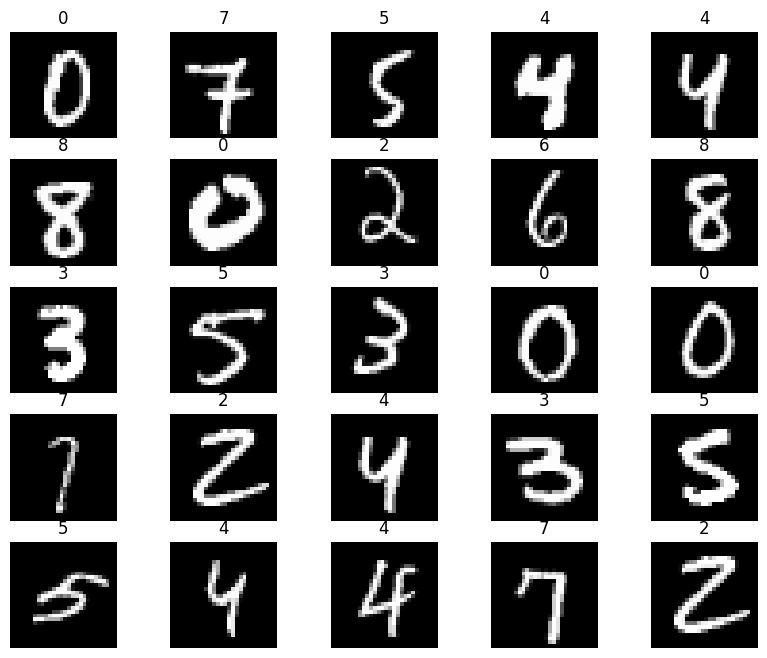

In [123]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images_tensor), size=(1,)).item()
    img = images_tensor[sample_idx]
    label = labels_tensor[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Building `DataLoaders` classes to load data

In [124]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Define data loaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader,
}

print("Data loaders have been created!")

Data loaders have been created!


In [125]:
print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x296384ca0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x2963840a0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x296384460>}


## Using the `dataloader`

torch.Size([100, 1, 28, 28])


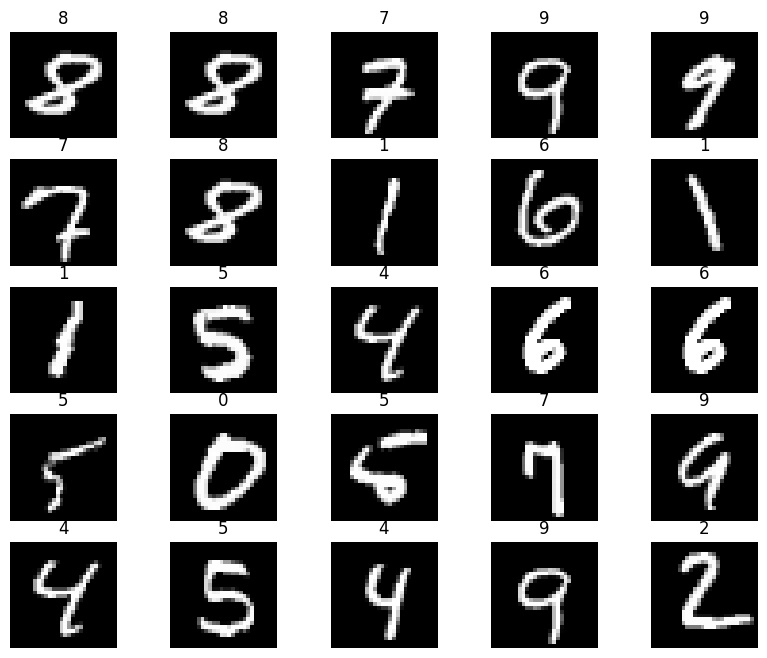

In [126]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

imgs, labels = next(iter(loaders['train']))
print(imgs.shape)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(imgs.shape[0], size=(1,)).item()
    img, label = imgs[sample_idx,:,:,:], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model

In [127]:
import torch.nn as nn
import torch.nn.functional as F

# Define the one-block CNN model
class OneBlockCNN(nn.Module):
    def __init__(self):
        super(OneBlockCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class TwoBlockCNN(nn.Module):
    def __init__(self):
        super(TwoBlockCNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return F.log_softmax(output, dim=1)  


In [128]:
model_one_block = OneBlockCNN()
model_two_block = TwoBlockCNN()

print(f"one_block_CNN: {model_one_block}")
print(f"two_block_CNN: {model_two_block}")

one_block_CNN: OneBlockCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
two_block_CNN: TwoBlockCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## Loss function

In [129]:
loss_func = nn.NLLLoss()
print(loss_func)

NLLLoss()


## Optimizer

In [130]:
from torch import optim
optimizer_one_block = optim.Adam(model_one_block.parameters(), lr=0.001)
optimizer_two_block = optim.Adam(model_two_block.parameters(), lr=0.001)

## Train the model

In [131]:
num_epochs = 10

def train(num_epochs, cnn, loaders, optimizer):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            output = cnn(images)
            loss = loss_func(output, labels)

            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward() # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            

In [132]:
model_one_block_training = train(num_epochs, model_one_block, loaders, optimizer_one_block)
model_two_block_training = train(num_epochs, model_two_block, loaders, optimizer_two_block)

## Test the model on test dataset

In [133]:
def test(cnn, loaders):
    cnn.eval()  
    
    with torch.no_grad():
        for images, labels in loaders['test']:
            test_output = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 200 test images: %.2f' % accuracy)

In [134]:
test(model_one_block, loaders)
test(model_two_block, loaders)


Test Accuracy of the model on the 200 test images: 0.78
Test Accuracy of the model on the 200 test images: 0.45


## Print predictions

In [135]:
def visualize_predictions(model, loader, num_images=25):
    imgs, lbls = next(iter(loader))
    true_labels = lbls[:num_images].numpy()
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    with torch.no_grad():
        test_output = model(imgs[:num_images])
        pred_labels = torch.max(test_output, 1)[1].data.numpy().squeeze()

    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5

    for i in range(1, cols * rows + 1):
        img, pred_label = imgs[i-1,:,:,:], pred_labels[i-1].item()
        figure.add_subplot(rows, cols, i)
        plt.title(pred_label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

    print(f'Prediction number: \t {pred_labels}')
    print(f'Actual number: \t \t {true_labels}')

One Block CNN Model Predictions:


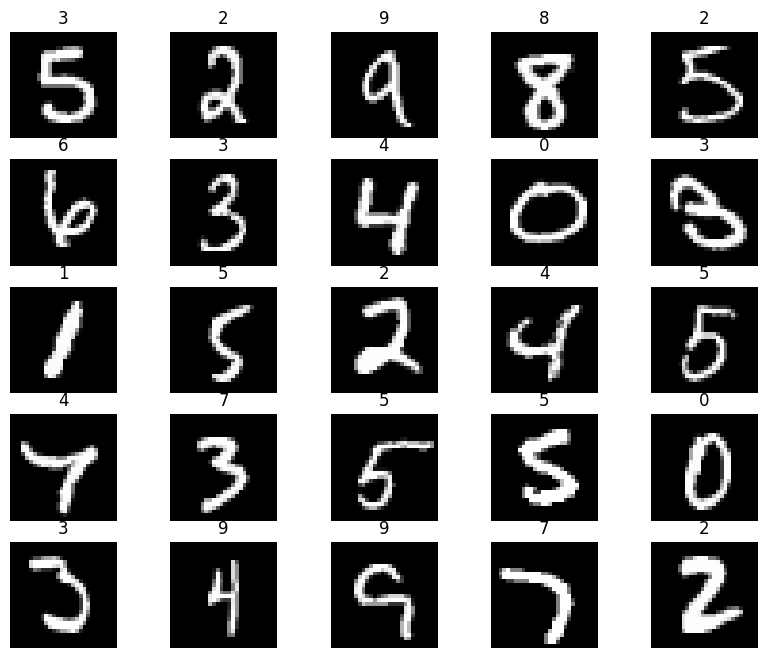

Prediction number: 	 [3 2 9 8 2 6 3 4 0 3 1 5 2 4 5 4 7 5 5 0 3 9 9 7 2]
Actual number: 	 	 [5 2 9 8 5 6 3 4 0 3 1 5 2 4 5 7 3 5 5 0 3 4 9 7 2]
Two Block CNN Model Predictions:


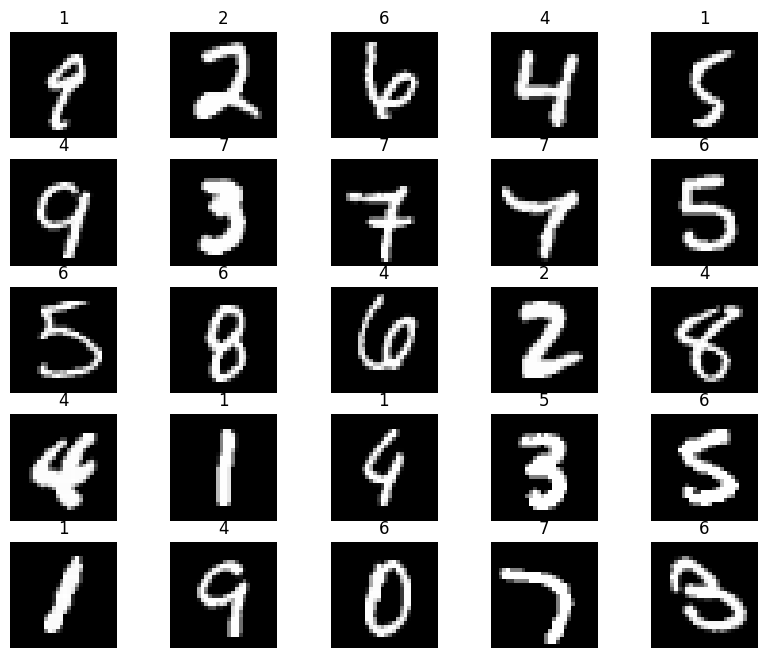

Prediction number: 	 [1 2 6 4 1 4 7 7 7 6 6 6 4 2 4 4 1 1 5 6 1 4 6 7 6]
Actual number: 	 	 [9 2 6 4 5 9 3 7 7 5 5 8 6 2 8 4 1 4 3 5 1 9 0 7 3]


In [136]:
# Visualize predictions for the one-block model
print("One Block CNN Model Predictions:")
visualize_predictions(model_one_block, loaders['test'])

# Visualize predictions for the two-block model
print("Two Block CNN Model Predictions:")
visualize_predictions(model_two_block, loaders['test'])

## Benchmark Performance using Different Optimization Techniques

In [137]:
### model_one_block ###
print("model_one_block")
# SGD
optimizer_sgd = optim.SGD(model_one_block.parameters(), lr=0.01)
train(num_epochs, model_one_block, loaders, optimizer_sgd)
test(model_one_block, loaders)

# SGD with Momentum
optimizer_momentum = optim.SGD(model_one_block.parameters(), lr=0.01, momentum=0.9)
train(num_epochs, model_one_block, loaders, optimizer_momentum)
test(model_one_block, loaders)

# ADAM
optimizer_adam = optim.Adam(model_one_block.parameters(), lr=0.001)
train(num_epochs, model_one_block, loaders, optimizer_adam)
test(model_one_block, loaders)

### model_two_block ###
print("model_two_block")
# SGD
optimizer_sgd = optim.SGD(model_two_block.parameters(), lr=0.01)
train(num_epochs, model_two_block, loaders, optimizer_sgd)
test(model_two_block, loaders)

# SGD with Momentum
optimizer_momentum = optim.SGD(model_two_block.parameters(), lr=0.01, momentum=0.9)
train(num_epochs, model_two_block, loaders, optimizer_momentum)
test(model_two_block, loaders)

# ADAM
optimizer_adam = optim.Adam(model_two_block.parameters(), lr=0.001)
train(num_epochs, model_two_block, loaders, optimizer_adam)
test(model_two_block, loaders)


model_one_block
Test Accuracy of the model on the 200 test images: 0.72
Test Accuracy of the model on the 200 test images: 0.85
Test Accuracy of the model on the 200 test images: 0.85
model_two_block
Test Accuracy of the model on the 200 test images: 0.65
Test Accuracy of the model on the 200 test images: 0.80
Test Accuracy of the model on the 200 test images: 0.82


## Testing overfitting and underfitting

In [138]:
class OverfitOneBlockCNN(nn.Module):
    def __init__(self):
        super(OverfitOneBlockCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, 1) # Increase number of filters to make it more complex
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 12 * 12, 512) # Increase number of nodes in the FC layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
class UnderfitOneBlockCNN(nn.Module):
    def __init__(self):
        super(UnderfitOneBlockCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, 1) # Decrease number of filters to make it simpler
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 12 * 12, 32) # Decrease number of nodes in the FC layer
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 4 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class OverfitTwoBlockCNN(nn.Module):
    def __init__(self):
        super(OverfitTwoBlockCNN, self).__init__()
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 64, 5, 1, 2),    # Increase number of filters
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 128, 5, 1, 2),  # Increase number of filters
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # Increase number of nodes in the FC layer
        self.out = nn.Linear(128 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return F.log_softmax(output, dim=1)


class UnderfitTwoBlockCNN(nn.Module):
    def __init__(self):
        super(UnderfitTwoBlockCNN, self).__init__()
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 4, 5, 1, 2),    # Decrease number of filters
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(4, 8, 5, 1, 2),   # Decrease number of filters
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # Decrease number of nodes in the FC layer
        self.out = nn.Linear(8 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return F.log_softmax(output, dim=1)


## Modified training function

In [139]:
# Modifying the train function to return train and validation losses for each epoch

def modified_train(num_epochs, cnn, loaders, optimizer):
    
    cnn.train()
    
    # Lists to store training and validation losses
    train_losses = []
    val_losses = []
    
    # Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        for i, (images, labels) in enumerate(loaders['train']):
            output = cnn(images)
            loss = loss_func(output, labels)
            optimizer.zero_grad()           
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / total_step
        train_losses.append(avg_train_loss)
        
        # Validation
        val_loss = 0
        cnn.eval()
        with torch.no_grad():
            for images, labels in loaders['val']:
                output = cnn(images)
                loss = loss_func(output, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(loaders['val'])
        val_losses.append(avg_val_loss)
        
        cnn.train()
        
        print ('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}' 
               .format(epoch + 1, num_epochs, avg_train_loss, avg_val_loss))
        
    return train_losses, val_losses

model_one_block: 
Epoch [1/10], Train Loss: 2.2857, Validation Loss: 2.0402
Epoch [2/10], Train Loss: 1.9685, Validation Loss: 1.7385
Epoch [3/10], Train Loss: 1.6057, Validation Loss: 1.5385
Epoch [4/10], Train Loss: 1.3690, Validation Loss: 1.3005
Epoch [5/10], Train Loss: 1.1016, Validation Loss: 1.1293
Epoch [6/10], Train Loss: 0.9269, Validation Loss: 0.9789
Epoch [7/10], Train Loss: 0.7252, Validation Loss: 0.8484
Epoch [8/10], Train Loss: 0.5788, Validation Loss: 0.7331
Epoch [9/10], Train Loss: 0.4641, Validation Loss: 0.6645
Epoch [10/10], Train Loss: 0.3674, Validation Loss: 0.6348
model_two_block: 
Epoch [1/10], Train Loss: 2.2992, Validation Loss: 2.2604
Epoch [2/10], Train Loss: 2.2231, Validation Loss: 2.2239
Epoch [3/10], Train Loss: 2.1756, Validation Loss: 2.1932
Epoch [4/10], Train Loss: 2.0981, Validation Loss: 2.1401
Epoch [5/10], Train Loss: 2.0020, Validation Loss: 2.0234
Epoch [6/10], Train Loss: 1.9086, Validation Loss: 1.8567
Epoch [7/10], Train Loss: 1.7935, V

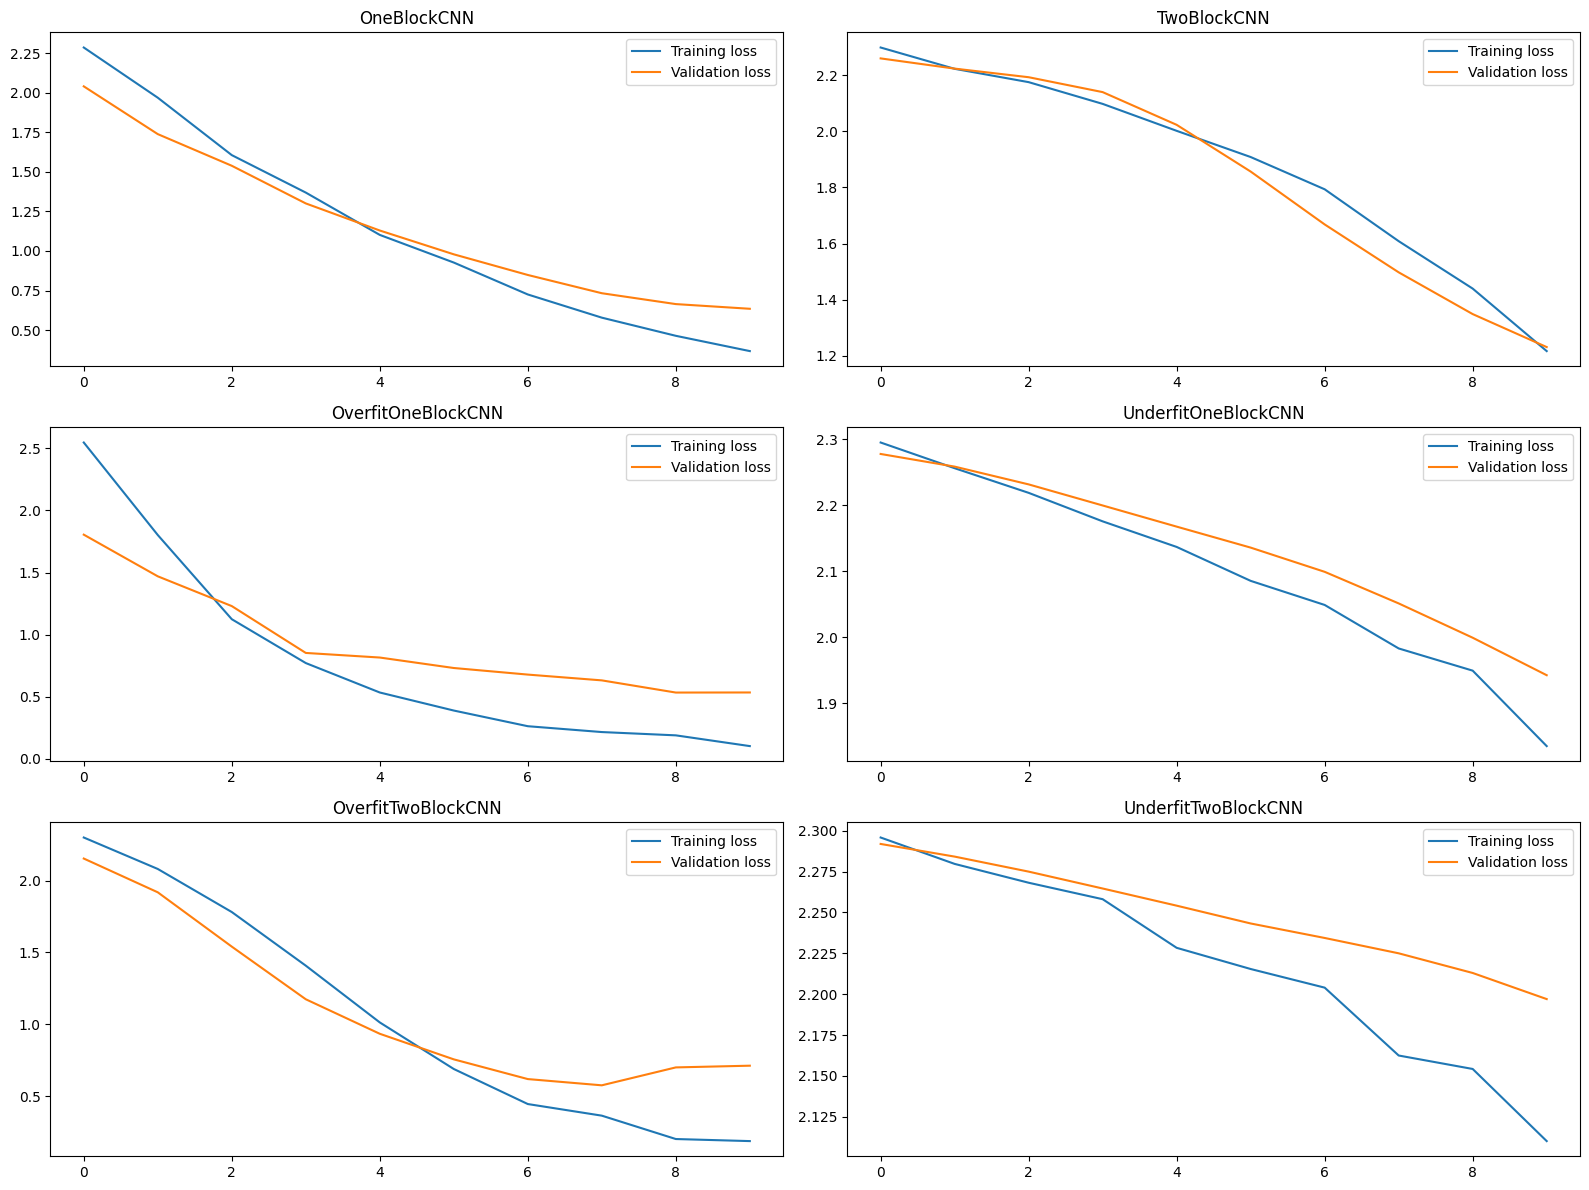

In [144]:
# Resetting the models and optimizers

model_one_block = OneBlockCNN()
optimizer_one_block = optim.Adam(model_one_block.parameters(), lr=0.001)

model_two_block = TwoBlockCNN()
optimizer_two_block = optim.Adam(model_two_block.parameters(), lr=0.001)

model_overfit_one_block = OverfitOneBlockCNN()
optimizer_overfit_one_block = optim.Adam(model_overfit_one_block.parameters(), lr=0.001)

model_underfit_one_block = UnderfitOneBlockCNN()
optimizer_underfit_one_block = optim.Adam(model_underfit_one_block.parameters(), lr=0.001)

model_overfit_two_block = OverfitTwoBlockCNN()
optimizer_overfit_two_block = optim.Adam(model_overfit_two_block.parameters(), lr=0.001)

model_underfit_two_block = UnderfitTwoBlockCNN()
optimizer_underfit_two_block = optim.Adam(model_underfit_two_block.parameters(), lr=0.001)

# Train each model
print("model_one_block: ")
train_losses_one_block, val_losses_one_block = modified_train(num_epochs, model_one_block, loaders, optimizer_one_block)
print("model_two_block: ")
train_losses_two_block, val_losses_two_block = modified_train(num_epochs, model_two_block, loaders, optimizer_two_block)
print("model_overfit_one_block: ")
train_losses_overfit_one_block, val_losses_overfit_one_block = modified_train(num_epochs, model_overfit_one_block, loaders, optimizer_overfit_one_block)
print("model_underfit_one_block: ")
train_losses_underfit_one_block, val_losses_underfit_one_block = modified_train(num_epochs, model_underfit_one_block, loaders, optimizer_underfit_one_block)
print("model_overfit_two_block: ")
train_losses_overfit_two_block, val_losses_overfit_two_block = modified_train(num_epochs, model_overfit_two_block, loaders, optimizer_overfit_two_block)
print("model_underfit_two_block: ")
train_losses_underfit_two_block, val_losses_underfit_two_block = modified_train(num_epochs, model_underfit_two_block, loaders, optimizer_underfit_two_block)

plt.figure(figsize=(16, 12))  

# OneBlockCNN
plt.subplot(3, 2, 1)
plt.plot(train_losses_one_block, label='Training loss')
plt.plot(val_losses_one_block, label='Validation loss')
plt.legend()
plt.title("OneBlockCNN")

# TwoBlockCNN
plt.subplot(3, 2, 2)
plt.plot(train_losses_two_block, label='Training loss')
plt.plot(val_losses_two_block, label='Validation loss')
plt.legend()
plt.title("TwoBlockCNN")

# OverfitOneBlockCNN
plt.subplot(3, 2, 3)
plt.plot(train_losses_overfit_one_block, label='Training loss')
plt.plot(val_losses_overfit_one_block, label='Validation loss')
plt.legend()
plt.title("OverfitOneBlockCNN")

# UnderfitOneBlockCNN
plt.subplot(3, 2, 4)
plt.plot(train_losses_underfit_one_block, label='Training loss')
plt.plot(val_losses_underfit_one_block, label='Validation loss')
plt.legend()
plt.title("UnderfitOneBlockCNN")

# OverfitTwoBlockCNN
plt.subplot(3, 2, 5)
plt.plot(train_losses_overfit_two_block, label='Training loss')
plt.plot(val_losses_overfit_two_block, label='Validation loss')
plt.legend()
plt.title("OverfitTwoBlockCNN")

# UnderfitTwoBlockCNN
plt.subplot(3, 2, 6)
plt.plot(train_losses_underfit_two_block, label='Training loss')
plt.plot(val_losses_underfit_two_block, label='Validation loss')
plt.legend()
plt.title("UnderfitTwoBlockCNN")

plt.tight_layout()
plt.show()


model_one_block:
Training Loss: Steadily decreases over epochs.
Validation Loss: Also decreases.
Diagnosis: This model shows good performance. The training loss consistently decreases over epochs, indicating effective learning. The validation loss follows a similar trend, demonstrating that the model generalizes well to unseen data. This behavior suggests a well-fitted model for the given task.

model_two_block:
Training Loss: Steadily decreases over epochs.
Validation Loss: Also decreases.
Diagnosis: Similar to model_one_block, this model exhibits effective learning and generalization. The training loss steadily decreases as the model learns from the data, and the validation loss also decreases, indicating good generalization. Like model_one_block, this model appears well-fitted to the task.

OverfitOneBlockCNN:
Training Loss: Steadily decreases over epochs.
Validation Loss: Also decreases.
Diagnosis: This model appears to perform well without overfitting. The validation loss tracks the training loss closely, suggesting that it generalizes to the validation data effectively.

UnderfitOneBlockCNN:
Training Loss: High and remains high.
Validation Loss: High and remains high.
Diagnosis: This model shows typical signs of underfitting. Both the training and validation losses are high and don't show significant improvement over time, indicating that the model is too simple to capture the underlying patterns in the data.

OverfitTwoBlockCNN:
Training Loss: Decreases significantly over epochs.
Validation Loss: Also decreases but not as much, indicating potential overfitting.
Diagnosis: The model shows signs of overfitting. While the training loss decreases faster, the validation loss decreases more slowly, suggesting that the model is fitting the training data too closely and may not generalize well to new data.

UnderfitTwoBlockCNN:
Training Loss: High and remains high.
Validation Loss: High and remains high.
Diagnosis: Similar to the UnderfitOneBlockCNN model, this model exhibits underfitting behavior. Both the training and validation losses are consistently high, indicating that the model is too simple to capture the dataset's patterns.

The model_two_block model seem to be the best suited model for this task.